# **Explore Data Sets**

**Goal**: To explore the dataset by looking at images of crops, some with healthy and some with different diseases.

**Objectives**

- Check properties of the image data.
- Normalize the dataset.
- Check the number of data points in each class.
- Balance the classes, so each ha the same number of observations.

In [1]:
import os
import random
from shutil import copy2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import PIL
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.5.1+cpu
torchvision version :  0.20.1+cpu
numpy version :  1.26.3
matplotlib version :  3.8.3
Python 3.12.1


**1. Exploring Data**

In [3]:
data_dir = "data_p2"
train_dir = os.path.join(data_dir, "train")

print("Data directory:", train_dir)

Data directory: data_p2\train


In [4]:
classes = os.listdir(train_dir)
classes

['cassava-bacterial-blight-cbb',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-healthy',
 'cassava-mosaic-disease-cmd']

Open an image with PIL

In [5]:
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

Looking at some healthy plants:

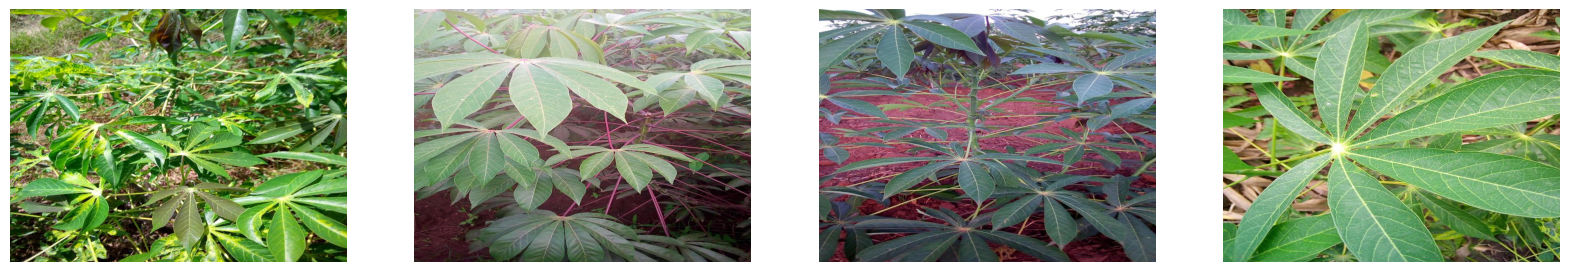

In [51]:
sample_images(train_dir, "cassava-healthy")

Green Motle

cassava-healthy


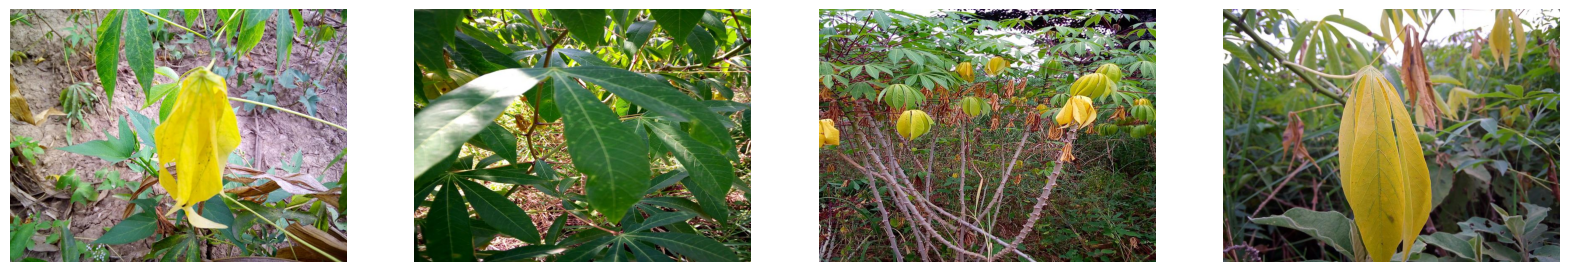

In [52]:
class_name = classes[3]
print(class_name)

sample_images(train_dir, class_name)

bacterial blight:

cassava-bacterial-blight-cbb


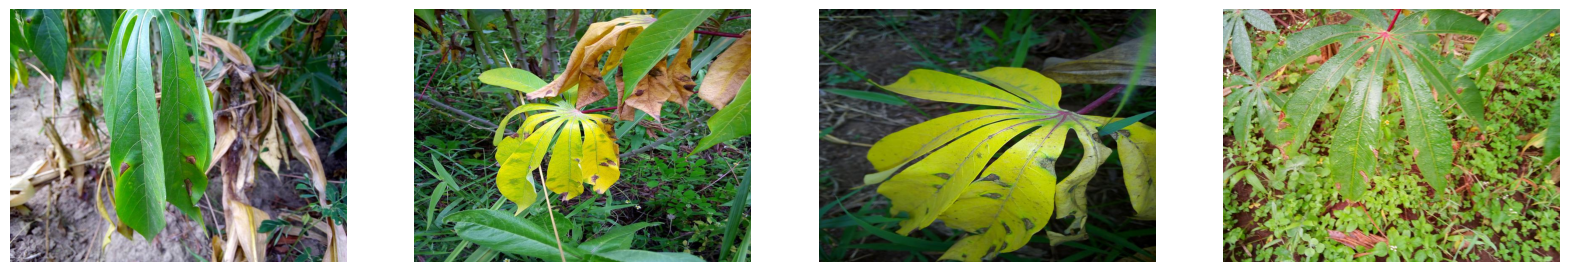

In [53]:
class_name = classes[0]
print(class_name)

sample_images(train_dir, class_name)

Mosaic:

cassava-mosaic-disease-cmd


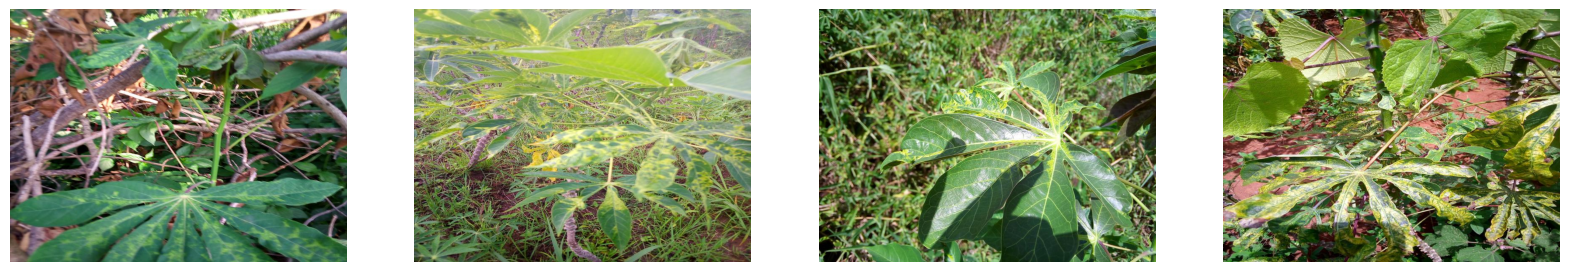

In [54]:
class_name = classes[4]
print(class_name)

sample_images(train_dir, class_name)

**1. Preparing Data**

We create a transformation that:
- Convert any grayscale images to RGB format with a custom class.
- Resize the image, so that they're all the same size (we chose 224 x 224, but other sizes would work as well).
- Convert the image to a Tensor of pixel values.

In [59]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [60]:
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [61]:
batch_size = 32
dataset = datasets.ImageFolder(root=train_dir, transform=transform_basic)
dataset_loader = DataLoader(dataset, batch_size)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


**2. Normalize Data**

In [62]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/669 [00:00<?, ?it/s]

Transform norm - normalize dataset_loader:

In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [ ]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size)

batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Verify normalization:

In [ ]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

**3. Train-Validation Split**